In [1]:
import importlib
import json
from pathlib import Path
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformer_lens  # type: ignore[import]
from jaxtyping import Float, Int
from matplotlib.axes._axes import Axes
from n2g import FeatureModel, NeuronStats, Tokenizer
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint  # type: ignore[import]

from thesis import n2g
from thesis.device import Device
from thesis.mas import WeightedSamplesStore, html
from thesis.sae.sae import SparseAutoencoder

/home/user/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = Device.get()

lm = HookedTransformer.from_pretrained("gelu-1l", device=device.torch())
tokenizer = Tokenizer(lm)

Loaded pretrained model gelu-1l into HookedTransformer


In [3]:
Path("~/Downloads/gelu-1l-sae_store.zip").expanduser()

PosixPath('/home/user/Downloads/gelu-1l-sae_store.zip')

In [4]:
mas_path = Path("../outputs/gelu-1l_sae_store.zip")
mas_store = WeightedSamplesStore.load(mas_path, device)
mas_store.num_samples_added()

43395

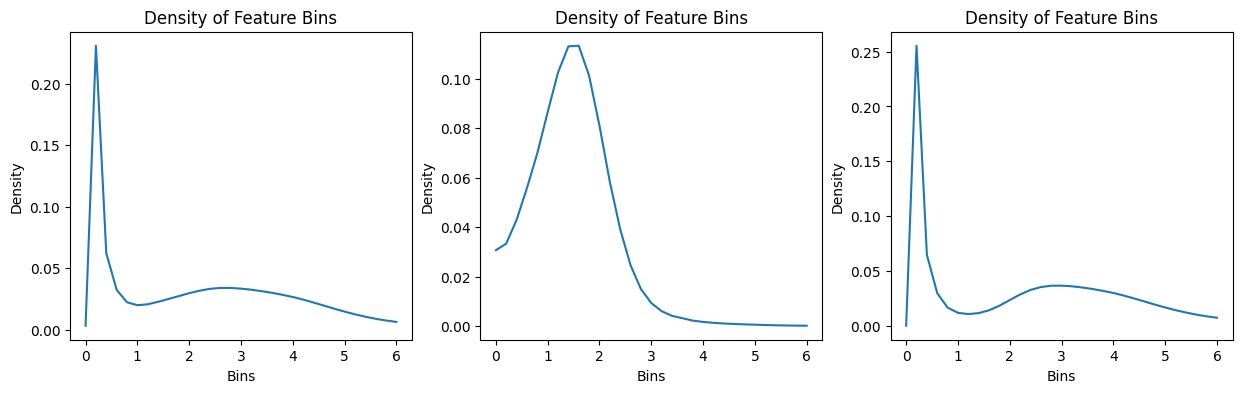

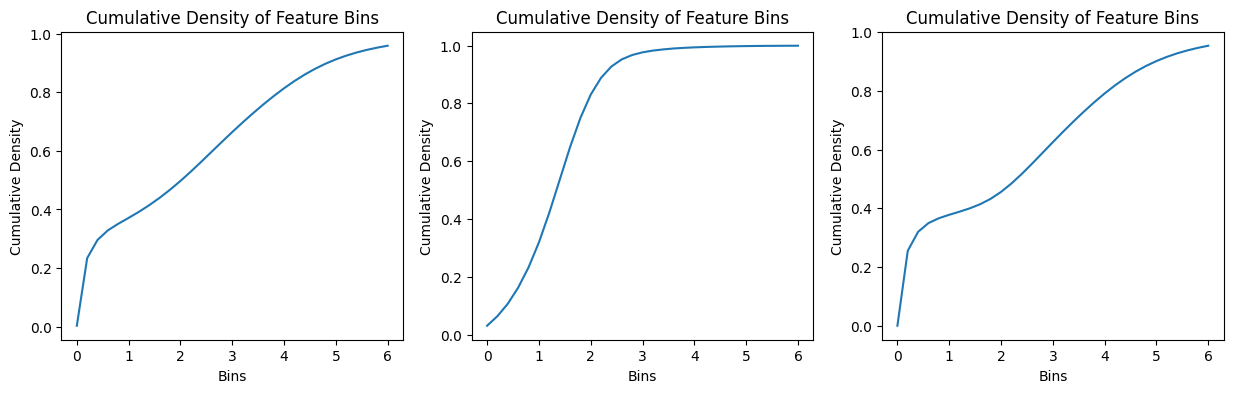

In [5]:
bins = mas_store.activation_bins.cpu().numpy()
plot_bins = np.append(bins, np.inf)
densities = mas_store.feature_densities.cpu().numpy()


def plot_density(
    ax: Axes, plot_bins: Float[np.ndarray, " num_bins"], densities: Float[np.ndarray, "num_features num_bins"]
) -> None:
    densities = densities.sum(axis=0) / densities.sum()
    data = {"bins": plot_bins, "densities": densities}
    global_df = pd.DataFrame(data)

    sns.lineplot(data=global_df, x="bins", y="densities", ax=ax)

    ax.set_xlabel("Bins")
    ax.set_ylabel("Density")
    ax.set_title("Density of Feature Bins")


def plot_cum_density(
    ax: Axes, plot_bins: Float[np.ndarray, " num_bins"], densities: Float[np.ndarray, "num_features num_bins"]
) -> None:
    densities = densities.sum(axis=0) / densities.sum()
    cum_densities = densities.cumsum(0)
    data = {"bins": plot_bins, "cumulative_densities": cum_densities}
    global_df = pd.DataFrame(data)

    sns.lineplot(data=global_df, x="bins", y="cumulative_densities", ax=ax)

    ax.set_xlabel("Bins")
    ax.set_ylabel("Cumulative Density")
    ax.set_title("Cumulative Density of Feature Bins")


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_density(axes[0], plot_bins, densities)
plot_density(axes[1], plot_bins, densities[:2048])
plot_density(axes[2], plot_bins, densities[2048:])
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_cum_density(axes[0], plot_bins, densities)
plot_cum_density(axes[1], plot_bins, densities[:2048])
plot_cum_density(axes[2], plot_bins, densities[2048:])
plt.show()

In [6]:
tokenizer = Tokenizer(lm)

n2g_models = n2g.load_all_models(tokenizer, Path("../outputs/gelu-1l_sae_n2g/models/all_models.bin"))

len(n2g_models)

18432

In [10]:
def activates_on(n2g_model: FeatureModel, tokens: str | list[str]) -> bool:
    if isinstance(tokens, str):
        tokens = [tokens]
    activating = [t for t, activating in n2g_model.tokens() if activating]
    return any(t in activating for t in tokens)


sm_n2g_indices = torch.tensor([i for i, model in enumerate(n2g_models) if activates_on(model, ["sm", " sm"])])
sm_n2g_indices - 2048

tensor([-365, -237, 1604, 7616])

In [17]:
hook_point = "blocks.0.mlp.hook_post"
sae = SparseAutoencoder.from_hf("NeelNanda/sparse_autoencoder", "25.pt", hook_point, device)


def sae_hook(activation: Float[Tensor, "batch context neurons_per_layer"], hook: HookPoint) -> None:
    activation[:] = sae.decode(sae.encode(activation))


def sae_alt_hook(activation: Float[Tensor, "batch context neurons_per_layer"], hook: HookPoint) -> None:
    latents = sae.encode(activation)
    print(sm_n2g_indices - 2048)
    print(activation.shape)
    latents[:, :, sm_n2g_indices - 2048] = 0
    activation[:] = sae.decode(latents)


sample = lm.to_tokens("the cat is sm")

top_logits, top_tokens = lm.run_with_hooks(sample, fwd_hooks=[])[0, -1, :].topk(k=5, dim=-1)
print(top_logits)
print(lm.to_str_tokens(top_tokens))
top_logits, top_tokens = lm.run_with_hooks(sample, fwd_hooks=[(hook_point, sae_hook)])[0, -1, :].topk(k=5, dim=-1)
print(top_logits)
print(lm.to_str_tokens(top_tokens))
top_logits, top_tokens = lm.run_with_hooks(sample, fwd_hooks=[(hook_point, sae_alt_hook)])[0, -1, :].topk(k=5, dim=-1)
print(top_logits)
print(lm.to_str_tokens(top_tokens))

tensor([19.3538, 17.9435, 17.9237, 17.4702, 17.4168], device='cuda:0',
       grad_fn=<TopkBackward0>)
['itten', 'ugg', 'othered', 'elly', 'ack']
tensor([14.7044, 14.4378, 13.9856, 13.8522, 13.7921], device='cuda:0',
       grad_fn=<TopkBackward0>)
['ok', 'ashing', 'elly', '.', 'othered']
tensor([-365, -237, 1604, 7616])
torch.Size([1, 5, 2048])
tensor([12.5003, 12.0659, 11.7760, 11.6591, 11.2654], device='cuda:0',
       grad_fn=<TopkBackward0>)
[',', ' to', '.', ' and', ' in']
